In [1]:
import pandas as pd 
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import seaborn as sns
import googletrans
from googletrans import Translator
from deep_translator import GoogleTranslator
import re
import nltk
from gensim.models import KeyedVectors
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to C:\Users\Xavier
[nltk_data]     Lee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Xavier
[nltk_data]     Lee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Xavier
[nltk_data]     Lee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Xavier
[nltk_data]     Lee\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Importing the dataset

In [2]:
df = pd.read_csv('Movie reviews.csv')

In [3]:
df

,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,NaN,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,NaN,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,NaN,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,NaN,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,NaN,Malay
...,...,...,...,...
522,Pening,0.7,NaN,Malay
523,Berkesan,0.2,NaN,Malay
524,Mengujakan,0.1,NaN,Malay
525,Sederhana and teruk,0.6,NaN,Malay


In [4]:
df.head(10)

,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.10,NaN,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.90,NaN,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.50,NaN,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.80,NaN,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.20,NaN,Malay
5,Pembuat filem berjaya memberikan pengalaman ya...,0.05,NaN,Malay
6,Adegan aksi yang terlalu banyak dan mengejutka...,0.40,NaN,Malay
7,Saya teruja sepanjang filem. Penceritaan yang ...,0.15,NaN,Malay
8,Avengers: Endgame mengecewakan dan membosankan...,0.85,NaN,Malay
9,Integrasi elemen fiksyen sains sangat menarik....,0.25,NaN,Malay


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 4 columns):
 #   Column                                                                                 Non-Null Count  Dtype  
---  ------                                                                                 --------------  -----  
 0   Review                                                                                 527 non-null    object 
 1   Score                                                                                  525 non-null    float64
 2   Are there ways for you to generate more data? Spliting up sentences, would that help?  0 non-null      float64
 3   Language                                                                               527 non-null    object 
dtypes: float64(2), object(2)
memory usage: 16.6+ KB


## Understanding the dataset
Columns:

- Review: Free-text movie review

- Score: A numerical value (0.0 to 1.0) — this suggests a regression or classification target.

- Language: e.g., Malay, possibly other languages

## Regression or classification?

Score ranges from 0.0 to 1.0 — we can:

- Convert it to classification (e.g., binary: positive/negative)

- Or do a regression if fine-grained sentiment is needed



# Exploratory Data Analysis and Data Preprocessing

## What we can infer from the dataset?
- After looking over the dataset, it would appear that the scoring system is inverted, meaning the reviews which are negative would be rated a high score (score >0.5) and reviews that are positive are given a lower score (score <0.5).
- This signifies an inverted scoring system where the more positive a review is, the lower the score can be expected.
- There also appears to be some anamolies included, such as when a review is obviously positive, they are given a very high score (score = 0.9, which is a very negative score). This could mean two things that are harming our dataset: 
    - Annotation error (labeling issues)
    - Sarcasm




## What should we do with the dataset now from this current point, based on what we can see at a first glance.
1. Find all the unique languages used in reviewing the movie
2. Label scores that are < 0.3 to be "positive" and scores > 0.7 to be "negative". While the scores in between will be labelled as neutral.
3. Labelled scores will be used for classification and the cleaned scores (floats).

In [6]:
# only keep necessary columns
df = df[['Review', 'Score', 'Language', ]]

In [7]:
# find all the unique languages in the dataset
unique_lang = df['Language'].unique()
print(unique_lang)

['Malay' 'English' 'Chinese' 'Nippon']


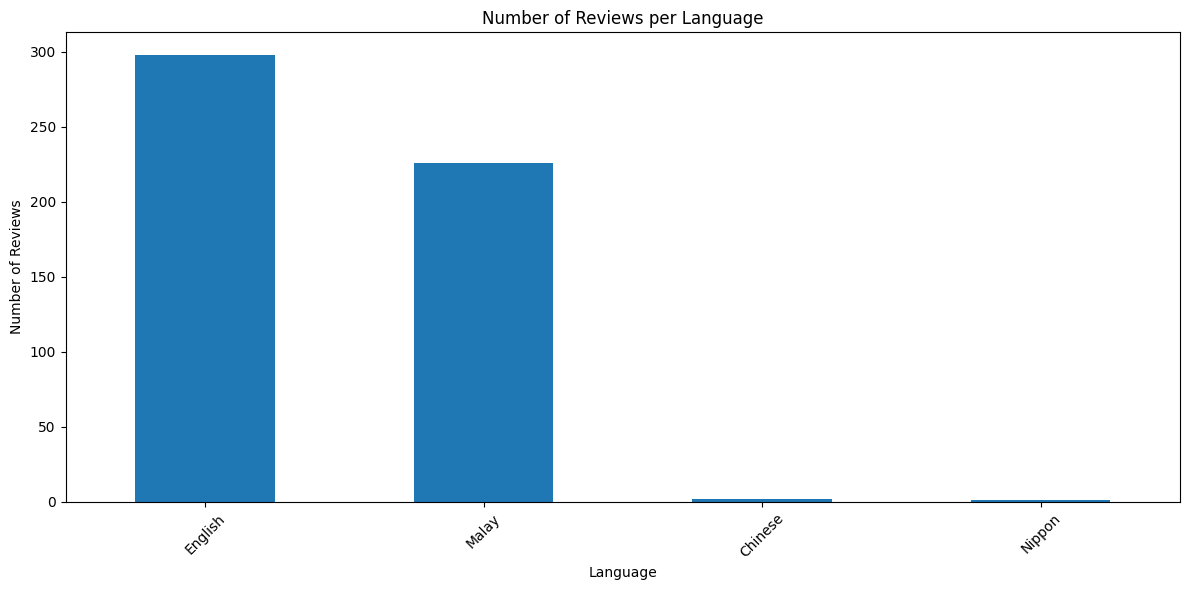

In [8]:
language_counts = df['Language'].value_counts()

# Plotting the number of unique rows
plt.figure(figsize=(12, 6))
language_counts.plot(kind='bar')
plt.title('Number of Reviews per Language')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Filter the dataset to only have 'Chinese' and 'Nippon' reviews
filtered_df_corrected = df[df['Language'].isin(['Chinese', 'Nippon'])]
filtered_df_corrected

,Review,Score,Language
426,Ni hao,NaN,Chinese
427,Hen tai fei chang hao,0.001000,Chinese
484,Nani kore,0.997413,Nippon


### As we can see from the dataset, the reviews that are written in Chinese and Nippon only have 3 rows of data. 
- after furthur investigation, these specific 3 rows of data are gibberish and add no real value to count towards our dataset.
- thus, we will drop them for the sake of our dataset.

In [10]:
# Drop the filtered rows from the original dataframe
df = df.drop(filtered_df_corrected.index)

In [11]:
# dataset that has chinese and nippon dropped
unique_lang = df['Language'].unique()
print(unique_lang)

['Malay' 'English']


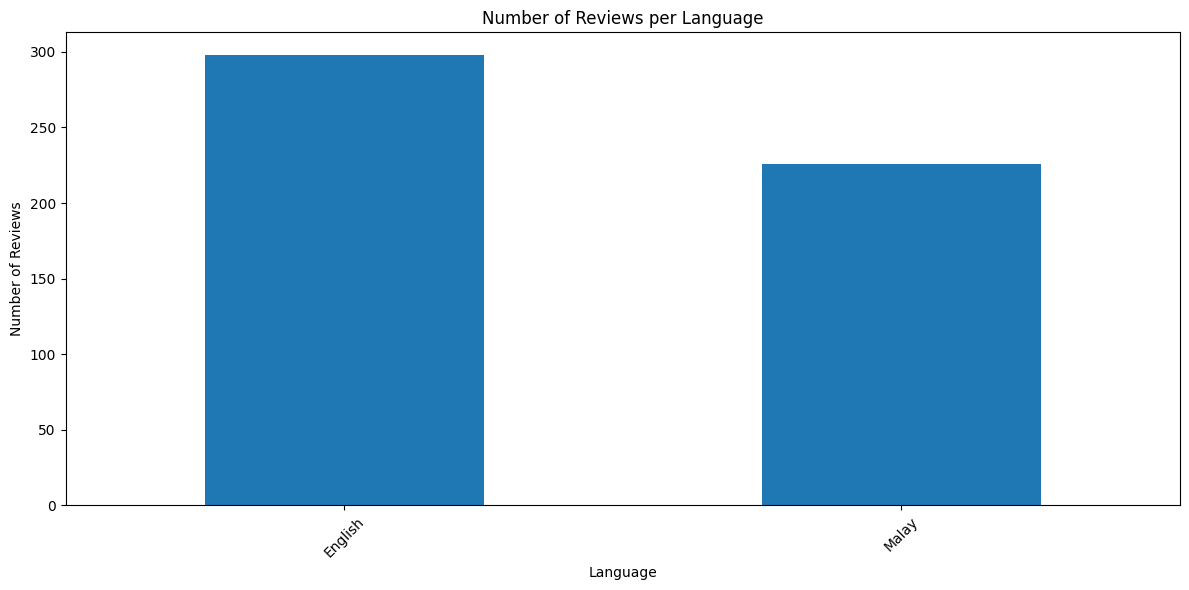

In [12]:
language_counts = df['Language'].value_counts()

# Plotting the number of unique rows
plt.figure(figsize=(12, 6))
language_counts.plot(kind='bar')
plt.title('Number of Reviews per Language')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Now that we have the cleaned dataset of gibberish data. lets now look at the duplicate sentences and words there are so far
- we can do so by splitting the reviews into individual words into a seperate column

In [13]:
# Sentence splitting using fallback regex
def simple_sentence_split(text):
    return re.split(r'(?<=[.!?])\s+', str(text).strip())

# Tokenize to sentences but retain the list structure 
df['sentences'] = df['Review'].apply(simple_sentence_split)

# Calculate number of sentences per review
df['num_sentences'] = df['sentences'].apply(len)

# Descriptive statistics for number of sentences per review
total_sentences = df['num_sentences'].sum()
sentence_distribution = df['num_sentences'].describe()

# Print out for analysis
print("Total number of sentences:", total_sentences)
print("Sentence count distribution:\n", sentence_distribution)

Total number of sentences: 980
Sentence count distribution:
 count    524.000000
mean       1.870229
std        0.667714
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: num_sentences, dtype: float64


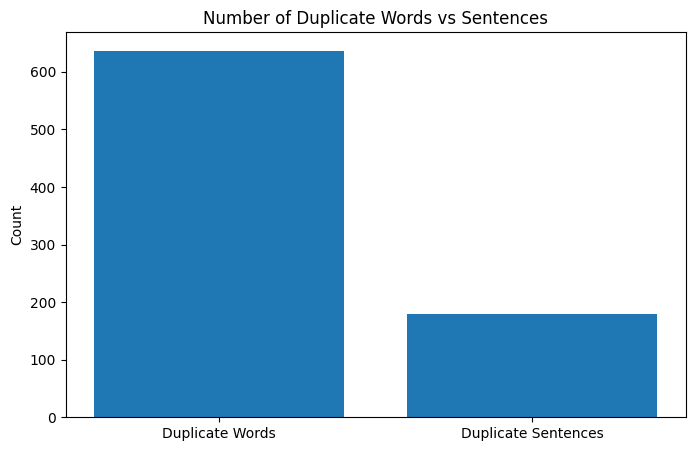

In [14]:
# Flatten all sentences across all reviews
all_sentences = [sentence for sublist in df['sentences'] for sentence in sublist]

# Count duplicate sentences
sentence_counts = Counter(all_sentences)
duplicate_sentences = {sentence: count for sentence, count in sentence_counts.items() if count > 1}

# Count duplicate words from all sentences
all_words = []
for sentence in all_sentences:
    words = re.findall(r'\b\w+\b', sentence.lower())
    all_words.extend(words)

word_counts = Counter(all_words)
duplicate_words = {word: count for word, count in word_counts.items() if count > 1}

# Get the most common duplicate words and sentences, sorted by frequency
top_duplicate_words = Counter(duplicate_words).most_common(10)
top_duplicate_sentences = Counter(duplicate_sentences).most_common(10)

# Convert to DataFrames for easier plotting
df_top_words = pd.DataFrame(top_duplicate_words, columns=['Word', 'Count'])
df_top_sentences = pd.DataFrame(top_duplicate_sentences, columns=['Sentence', 'Count'])

# Prepare labels for the bar chart
labels = ['Duplicate Words', 'Duplicate Sentences']
counts = [len(duplicate_words), len(duplicate_sentences)]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts)
plt.title('Number of Duplicate Words vs Sentences')
plt.ylabel('Count')
plt.show()

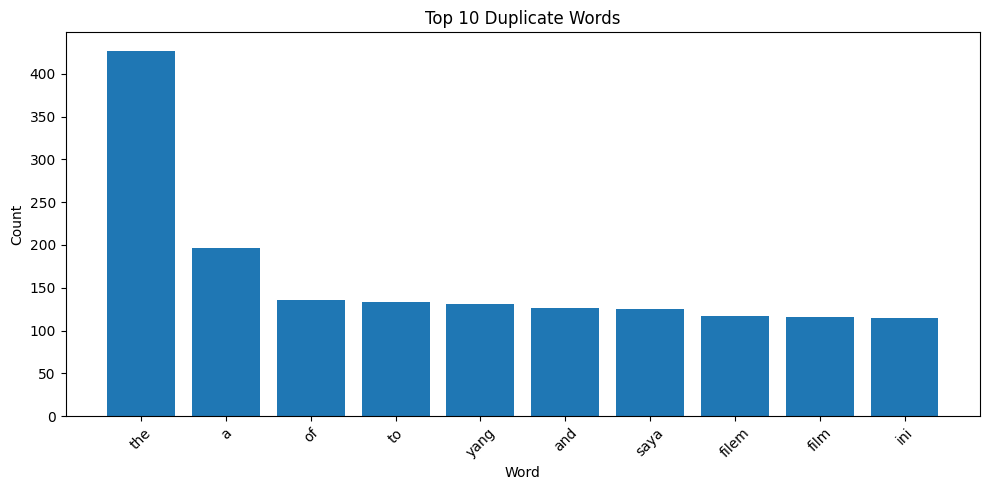

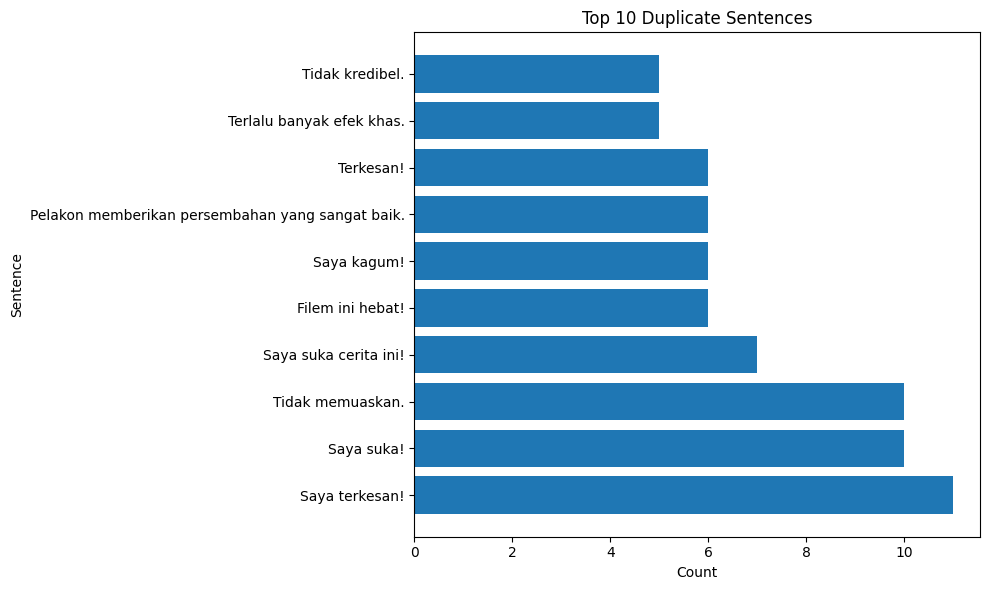

In [15]:
# Get the most common duplicate words and sentences, sorted by frequency
top_duplicate_words = Counter(duplicate_words).most_common(10)
top_duplicate_sentences = Counter(duplicate_sentences).most_common(10)
# Plot the top duplicate words
plt.figure(figsize=(10, 5))
plt.bar(df_top_words['Word'], df_top_words['Count'])
plt.title('Top 10 Duplicate Words')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Convert to DataFrames for easier viewing
df_top_words = pd.DataFrame(top_duplicate_words, columns=['Word', 'Count'])
df_top_sentences = pd.DataFrame(top_duplicate_sentences, columns=['Sentence', 'Count'])

# Plot the top duplicate sentences
plt.figure(figsize=(10, 6))
plt.barh(df_top_sentences['Sentence'], df_top_sentences['Count'])
plt.title('Top 10 Duplicate Sentences')
plt.xlabel('Count')
plt.ylabel('Sentence')
plt.tight_layout()
plt.show()

### Observations for duplicates:
- it would appear that most of our duplicate words are syncategorematic words (eg. a, the, of, to). meaning that they are words that they are words that do not stand by themselves and give no value to our sentiment analysis
- a majority of sentences with the most duplicates are in Malay. meaning we will have to translate them to english before tokenization.

### What can we do with the duplicated sentences and words and how to handle them?
- by doing a duplicate sentence analysis with the score we could be able to drop the sentences that are duplicates and have the same sentiment
- first we can do this by assigning labels to scores < 0.4 (positive), scores > 0.6 (negative) and anything in between to be neutral.

In [16]:
# Translate each sentence to English
def translate_to_english(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except Exception as e:
        print(f"Translation error: {text[:50]}... | {e}")
        return text  # fallback to original

# Apply translation
df['sentences'] = df['sentences'].apply(lambda sent_list: [translate_to_english(s) for s in sent_list])

# Explode list of sentences into one sentence per row
df_exploded = df.explode('sentences').reset_index(drop=True)
df_exploded = df_exploded.rename(columns={'sentences': 'sentence'})


In [17]:
# label for classification
def label_sentiment(score):
    try:
        score = float(score)
        if score <= 0.3:
            return 1  # Positive
        elif score >= 0.7:
            return 0  # Negative
        else:
            return 2  # Neutral
    except:
        return None 


def assign_sentiment_label(score):
    try:
        score = float(score)
        if score <= 0.3:
            return 'positive'
        elif score >= 0.7:
            return 'negative'
        else:
            return 'neutral'
    except:
        return 'unknown'


df_exploded['label'] = df_exploded['Score'].apply(label_sentiment)
df_exploded['Sentiment_Label'] = df_exploded['Score'].apply(assign_sentiment_label)


## Train test split
- why are we doing train test split now?
- because we do not want the possibility of having a leaky data to deal with later after augmentation.

In [18]:
# Extract features and labels
X = df_exploded['sentence'].astype(str).tolist()
y = df_exploded['label'].astype(int).tolist()

# Split only original (non-augmented) data
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    df_exploded['sentence'],
    df_exploded['label'],
    test_size=0.3,
    random_state=42,
    stratify=df_exploded['label']
)

### Now with the labelled sentiment for each review (postive, negative or neutral)
- we can proceed with dropping duplicate reviews with the same sentiment
    - an example,
      - review...............................................label
      - this movie was great!...........  positive
      - ~this movie was great!..........  positive~
- as for syncategorematic words, we will be using lemmatization and tokenization for cleaning. for English syncategorematic words, we will use nltk's library of stopwords. and as for Malay syncategorematic words, we will use a custom stopword outsourced from somewhere else. 

In [19]:
# Sentence splitting (assumes 'sentences' column is a list of sentences) 
df_exploded = df.explode('sentences').reset_index(drop=True)

# Reassign sentiment labels (needed after exploding)
df_exploded['label'] = df_exploded['Score'].apply(label_sentiment)

# Deduplicate by sentence and label 
df_deduped = df_exploded.drop_duplicates(subset=['sentences', 'label']).reset_index(drop=True)

# English stopwords
english_stopwords = set(stopwords.words('english'))

# Lemmatize/tokenize 
def clean_tokens(text):
    tokens = re.findall(r'\b\w+\b', str(text).lower())
    return [word for word in tokens if word not in english_stopwords]

# Apply to deduplicated DataFrame
df_deduped['cleaned_tokens'] = df_deduped['sentences'].apply(clean_tokens)

# Preview cleaned output
print(df_deduped[['sentences', 'label', 'cleaned_tokens']].head())

                               sentences  label  \
0                   This movie is great!      1   
1  Thrilling action and surprising plot.      1   
2                   This movie is great!      0   
3  Thrilling action and surprising plot.      0   
4                   This movie is great!      2   

                          cleaned_tokens  
0                         [movie, great]  
1  [thrilling, action, surprising, plot]  
2                         [movie, great]  
3  [thrilling, action, surprising, plot]  
4                         [movie, great]  


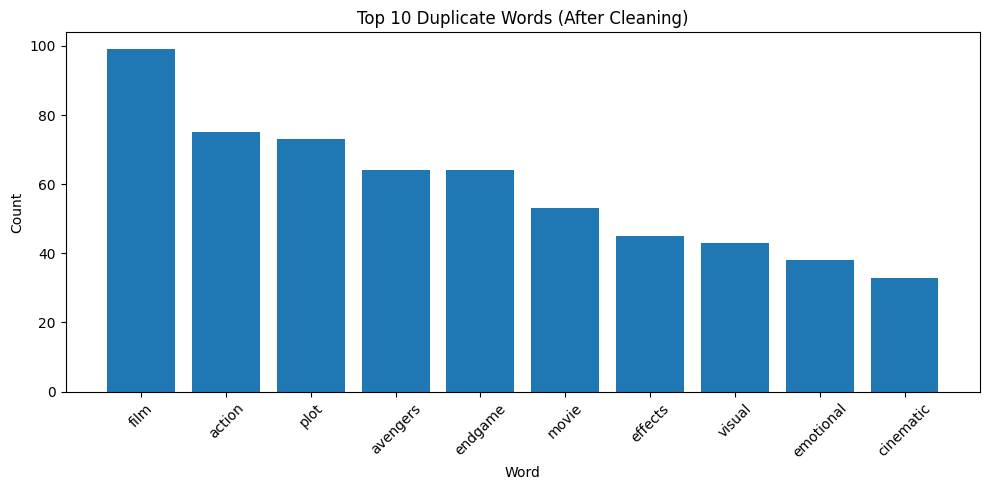

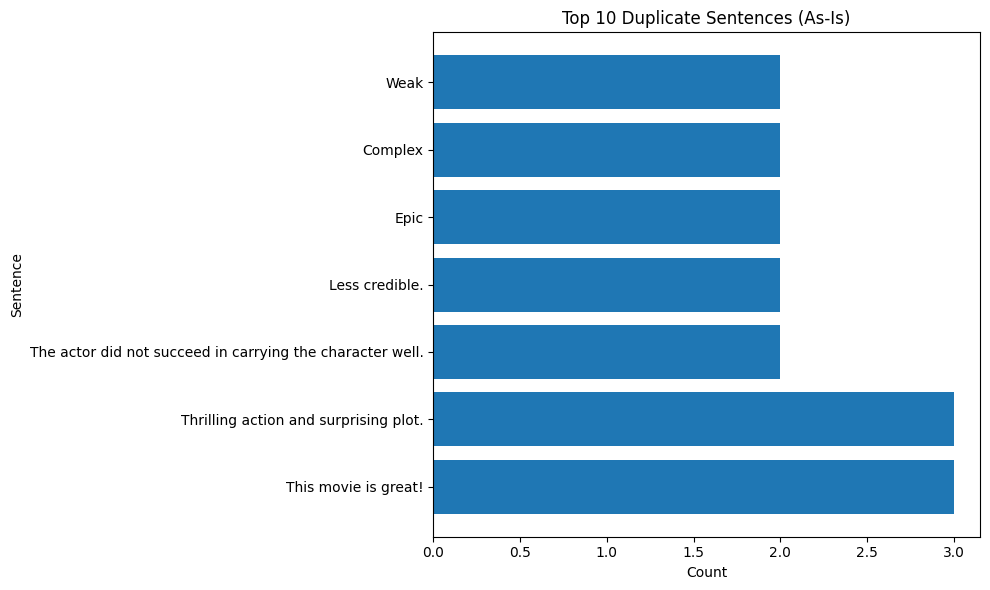

In [20]:
# Count and plot top duplicate words 
all_cleaned_words = [word for tokens in df_deduped['cleaned_tokens'] for word in tokens]
word_counts = Counter(all_cleaned_words)
top_duplicate_words = Counter({word: count for word, count in word_counts.items() if count > 1}).most_common(10)

df_top_words = pd.DataFrame(top_duplicate_words, columns=['Word', 'Count'])
plt.figure(figsize=(10, 5))
plt.bar(df_top_words['Word'], df_top_words['Count'])
plt.title('Top 10 Duplicate Words (After Cleaning)')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Count and plot top duplicate sentences (as-is, no cleaning) 
sentence_counts = Counter(df_deduped['sentences'])
top_duplicate_sentences = Counter({s: c for s, c in sentence_counts.items() if c > 1}).most_common(10)

df_top_sentences = pd.DataFrame(top_duplicate_sentences, columns=['Sentence', 'Count'])
plt.figure(figsize=(10, 6))
plt.barh(df_top_sentences['Sentence'], df_top_sentences['Count'])
plt.title('Top 10 Duplicate Sentences (As-Is)')
plt.xlabel('Count')
plt.ylabel('Sentence')
plt.tight_layout()
plt.show()

### Further analysis on duplicates
- after cleaning duplicates using our method. we can see that our data it alot cleaner now. with duplicate words not having syncategorematic words from both languages.
- there are still some duplicated words and sentences.
- however, the duplicate words are well within reason to be included when training as they provide context that is essential for sentiment analysis. thus, we no longer need to do anything with the duplicate words ✅✅✅
- as for the duplicate sentences however, i found it interesting as to why these 4 stood out from our dataset. and i asked myself these questions:
  1. why were there one worded sentences? and how could there be 2 different sentiment labels on the same word?
  2. how could the same exact sentence have 3 possible sentiment labels as well?

### What should we do to handle them?
- we need to find out how many of these one worded reviews there are and give them the correct sentiment label
- i suspect there to be sarcasm involved when the same review was given a score. we find a way to correctly label those sentences with 3 sentiment labels with the correct sentiment. 

- after looking at the dataset, i realise that the sentences with 3 sentiment labels are from the same sentence just with varying scores.
- and after running the sentence through a quick google translate, it actually meant "
This movie is great! Thrilling action and a surprising plot" which is very obviously a positive sentiment. Thus, i will drop the 2 of the same review that are neutral and negative and we are only left with one that has a score of 0.1 (positive sentiment)..

In [21]:
# Reassign sentiment label strings
df_deduped['Sentiment_Label'] = df_deduped['Score'].apply(assign_sentiment_label)

# Define the specific target sentences
sentences_to_fix = [
    "This movie is great!",
    "Thrilling action and surprising plot."
]

# Keep only the rows where:
# - the sentence is not one of the target ones OR
# - it is one of the target ones AND is labeled as 'positive'
df_deduped = df_deduped[
    ~((df_deduped['sentences'].isin(sentences_to_fix)) & (df_deduped['Sentiment_Label'] != 'positive'))
].reset_index(drop=True)

In [22]:
# check if a review contains exactly one word
def is_one_word_review(text):
    words = re.findall(r'\b\w+\b', str(text).strip())
    return len(words) == 1

# Apply the function to the 'Review' column
df['is_one_word'] = df['Review'].apply(is_one_word_review)

# Count the number of one-word reviews
one_word_review_count = df['is_one_word'].sum()

# Extract all one-word reviews
one_word_reviews = df[df['is_one_word']]['Review'].dropna().astype(str)

# Normalize and count frequencies
one_word_counts = Counter(one_word_reviews.str.lower())

# Get the top 10 most frequent one-word reviews
top_10_one_word_reviews = one_word_counts.most_common(10)

# Print them
print("Top 10 One-Word Reviews:")
for word, count in top_10_one_word_reviews:
    print(f"{word}: {count} times")
    
print(f"Number of one-word reviews: {one_word_review_count}")

Top 10 One-Word Reviews:
spectacular: 2 times
intriguing: 2 times
impressive: 2 times
complex: 2 times
moving: 2 times
weak: 2 times
masterpiece: 1 times
emotional: 1 times
epic: 1 times
thrilling: 1 times
Number of one-word reviews: 61


- after manually dropping the sentences that are labelled with the wrong sentiment, now we can also move onto doing the same with the one worded reviews.
- for example:
  - spectacular -> positive
  - weak -> negative

In [23]:
# Create normalized lowercase version of sentence for matching
df_deduped['sentences_lower'] = df_deduped['sentences'].str.lower().str.strip()

# List of one-word reviews that are duplicated
one_word_duplicates = ["spectacular", "intriguing", "impressive", "complex", "moving", "weak"]

# Define correct labels for each word (adjust if needed)
correct_labels = {
    "spectacular": "positive",
    "intriguing": "positive",
    "impressive": "positive",
    "complex": "neutral",
    "moving": "positive",
    "weak": "negative"
}

# Drop rows where the one-word sentence matches and the sentiment is NOT the correct one
df_deduped = df_deduped[
    ~(
        df_deduped['sentences_lower'].isin(correct_labels.keys()) &
        (df_deduped['Sentiment_Label'] != df_deduped['sentences_lower'].map(correct_labels))
    )
].drop(columns='sentences_lower').reset_index(drop=True)

### An observation when manually dropping duplicates:
- the one-worded "complex" had a duplicate but it was hard assigning it a sentiment as it is the type of word that needs to be put in a sentence for it to make sense whether it was negative, positive or neutral.
- so after some scraping in the dataset row by row, majority of the sentences that had "complex" in them are always neutral. thus, i am assigning "complex" to be a neutral sentiment.
- that was quite "complex" hahaamds

## Ending statments for exploratory data analysis and data preprocessing:
- we have so far managed to:
  - filter out words that have no meaning and are strictly for sentence structure
  - filter gibberish data (chinese and nippon)
  - solve and handle straight-forward and weird duplicates
  - manually label reviews with wrong sentiments

HOWEVER, the one-worded reviews caught my eye. And it made me think of what i could do for my feature engineering later. How can we use them to create more data?

# Feature Engineering 

In [24]:
df_deduped

,Review,Score,Language,sentences,num_sentences,label,cleaned_tokens,Sentiment_Label
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay,This movie is great!,2,1,"[movie, great]",positive
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay,Thrilling action and surprising plot.,2,1,"[thrilling, action, surprising, plot]",positive
2,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay,"Unfortunately, the actor didn't give the best ...",2,0,"[unfortunately, actor, give, best, performance]",negative
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay,Not satisfied.,2,0,[satisfied],negative
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,Malay,Complex and emotional storyline.,2,1,"[complex, emotional, storyline]",positive
...,...,...,...,...,...,...,...,...
645,Pening,0.7,Malay,Dizzy,1,0,[dizzy],negative
646,Berkesan,0.2,Malay,Effective,1,1,[effective],positive
647,Mengujakan,0.1,Malay,Exciting,1,1,[exciting],positive
648,Sederhana and teruk,0.6,Malay,Moderate and severe,1,2,"[moderate, severe]",neutral


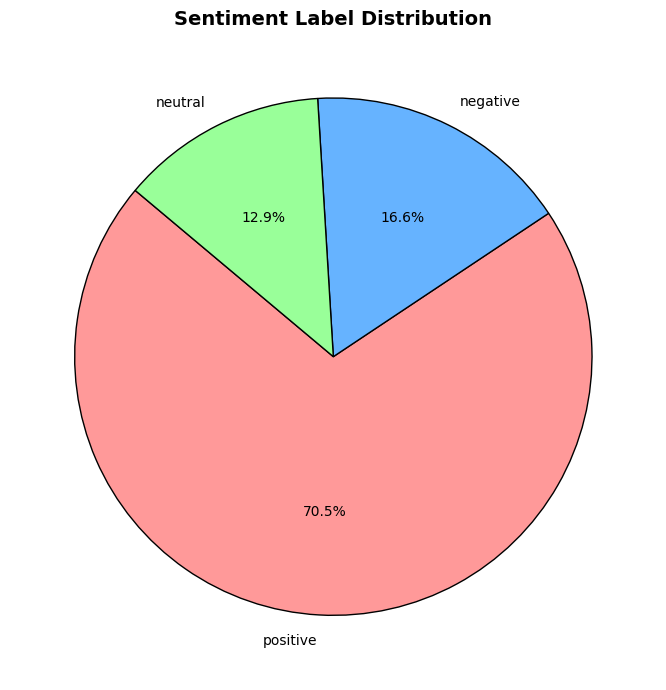

In [25]:
plt.figure(figsize=(7, 7))
df_deduped['Sentiment_Label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=140,
    colors=['#ff9999', '#66b3ff', '#99ff99'],
    wedgeprops={'edgecolor': 'black'}
)
plt.ylabel('')
plt.title('Sentiment Label Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


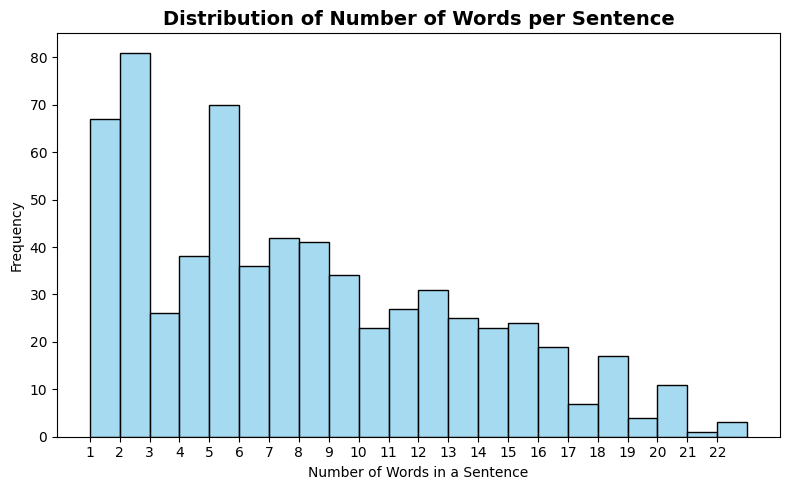

In [26]:
# Compute number of words per sentence
word_counts = [len(sentence.split()) for sentence in df_deduped['sentences']]

# Create histogram
plt.figure(figsize=(8, 5))
sns.histplot(word_counts, bins=range(1, max(word_counts)+2), kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Words per Sentence', fontsize=14, fontweight='bold')
plt.xlabel('Number of Words in a Sentence')
plt.ylabel('Frequency')
plt.xticks(range(1, max(word_counts)+1))
plt.tight_layout()
plt.show()

### First overview of our cleaned dataset
- now that we have a cleaned dataset, it's time to think of ways of how to expand and increase the amount of data that we have
- this might prove difficult because of the already limited data we already have
- but looking at the one and two worded reviews, it gave me an idea of how i can use Word Embedding.
- so far, this will be the flow of how i will generate more data:
  1. word embedding
  2. synonym replacement
  3. back translation

### Word Embedding-Based Augmentation
- Replaces one word in each sentence with a semantically similar word using Word2Vec.
- Helps generate new sentences with the same meaning but different wording.
- Focuses only on meaningful words (ignores stopwords).

Example:

- Original: "The movie was gripping and emotional"
- Augmented: "The movie was riveting and emotional"

In [27]:
# Load  pre-trained Google News Word2Vec model
model_path = "C:/Users/Xavier Lee/Downloads/GoogleNews-vectors-negative300.bin"
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

# Define stopwords
stop_words = set(stopwords.words('english'))

# Word Embedding-Based Sentence Augmentation 
def word_embedding_augment(sentence, model, max_attempts=10):
    words = re.findall(r'\b\w+\b', sentence)
    if len(words) < 2:
        return sentence  # skip too-short sentences

    # Choose candidate words to replace (not stopwords, must be in embedding model)
    candidate_indices = [i for i, word in enumerate(words) if word.lower() not in stop_words and word.lower() in model]

    if not candidate_indices:
        return sentence  # nothing to replace

    for _ in range(max_attempts):
        idx = random.choice(candidate_indices)
        original_word = words[idx].lower()

        try:
            similar_words = model.most_similar(original_word, topn=5)
            for sim_word, score in similar_words:
                if sim_word.lower() != original_word:
                    words[idx] = sim_word
                    return ' '.join(words)
        except KeyError:
            continue

    return sentence  # fallback if no replacements succeed

# Apply to your cleaned sentences
augmented_rows = []

for _, row in df_deduped.iterrows():
    original = row['sentences']
    augmented = word_embedding_augment(original, model)

    if augmented != original:
        augmented_rows.append({
            'sentences': augmented,
            'label': row['label'],
            'Sentiment_Label': row['Sentiment_Label'],
            'augmentation': 'embedding',
            'source_sentence': original
        })

df_augmented_embed = pd.DataFrame(augmented_rows)

# combine with df_deduped for final dataset
df_all = pd.concat([df_deduped, df_augmented_embed], ignore_index=True)

# Preview result
print(df_augmented_embed.head())

                                           sentences  label Sentiment_Label  \
0                             This movie is terrific      1        positive   
1              Thrilling actions and surprising plot      1        positive   
2  Unfortunately the actress didn t give the best...      0        negative   
3                                   Not dissatisfied      0        negative   
4                  Complex and emotionally storyline      1        positive   

  augmentation                                    source_sentence  
0    embedding                               This movie is great!  
1    embedding              Thrilling action and surprising plot.  
2    embedding  Unfortunately, the actor didn't give the best ...  
3    embedding                                     Not satisfied.  
4    embedding                   Complex and emotional storyline.  


### Short Sentence Expansion
- This step expands 1- to 2-word reviews into complete sentences using simple templates.
- It helps preserve valuable sentiment information from short inputs that would otherwise be weak signals to the model.
- Expansion is based on the sentiment label to maintain contextual accuracy.

Example:
- Original: "Spectacular" (positive) and "Weak" (negative)
- Expanded: "The movie was spectacular."
- Expanded: "The plot was weak."

In [28]:
# Filter short-sentence rows
short_reviews_df = df_all[df_all['cleaned_tokens'].apply(lambda x: isinstance(x, list) and len(x) <= 2)]

# Expand short reviews using simple templates
def expand_short_review(tokens, sentiment_label):
    if not tokens:
        return None
    
    text = ' '.join(tokens).lower()
    
    if len(tokens) == 1:
        if sentiment_label == 'positive':
            return f"The movie was {text}."
        elif sentiment_label == 'negative':
            return f"The plot was {text}."
        else:
            return f"The movie is {text}."
    
    elif len(tokens) == 2:
        if sentiment_label == 'positive':
            return f"This film is {text}."
        elif sentiment_label == 'negative':
            return f"The experience felt {text}."
        else:
            return f"The overall tone is {text}."
    
    return None  # fallback

# Generate augmented rows
expanded_rows = []

for _, row in short_reviews_df.iterrows():
    expanded = expand_short_review(row['cleaned_tokens'], row['Sentiment_Label'])
    if expanded:
        expanded_rows.append({
            'sentences': expanded,
            'label': row['label'],
            'Sentiment_Label': row['Sentiment_Label'],
            'augmentation': 'short_sentence_expansion',
            'source_sentence': ' '.join(row['cleaned_tokens']) if isinstance(row['cleaned_tokens'], list) else None
        })

df_augmented_short = pd.DataFrame(expanded_rows)

# Add to full dataset
df_all = pd.concat([df_all, df_augmented_short], ignore_index=True)

# Check sample
print(df_augmented_short.head())

                                sentences  label Sentiment_Label  \
0               This film is movie great.      1        positive   
1                 The plot was satisfied.      0        negative   
2             The movie was entertaining.      1        positive   
3           This film is really stunning.      1        positive   
4  This film is interesting storytelling.      1        positive   

               augmentation           source_sentence  
0  short_sentence_expansion               movie great  
1  short_sentence_expansion                 satisfied  
2  short_sentence_expansion              entertaining  
3  short_sentence_expansion           really stunning  
4  short_sentence_expansion  interesting storytelling  


### Synonym Replacement (WordNet)
- This step augments each sentence by replacing one word with up to 10 synonyms using WordNet.
- Only one word is replaced per sentence to preserve original context.
- Duplicate sentences generated across different reviews are removed to ensure variation.

Example:
- Original: "The plot was weak"
- Augmented: "The plot was feeble", "The plot was frail", "The plot was poor"



In [29]:
# Define a function to get N synonyms for one word in the sentence
def generate_synonym_variants(text, max_variants=10):
    words = text.split()
    variants = []

    # Shuffle to randomize word selection
    candidate_indices = list(range(len(words)))
    random.shuffle(candidate_indices)

    for idx in candidate_indices:
        word = words[idx]
        synonyms = wordnet.synsets(word)

        synonym_words = set()
        for syn in synonyms:
            for lemma in syn.lemmas():
                lemma_word = lemma.name().replace('_', ' ')
                if lemma_word.lower() != word.lower():
                    synonym_words.add(lemma_word)

        # If synonyms found, create variants
        if synonym_words:
            for i, synonym in enumerate(list(synonym_words)[:max_variants]):
                new_words = words.copy()
                new_words[idx] = synonym
                new_sentence = ' '.join(new_words)
                variants.append(new_sentence)
            break  # only replace one word per sentence

    return variants

# Apply across df_all
augmented_synonym_rows = []

for _, row in df_all.iterrows():
    original_sentence = row['sentences']
    
    if isinstance(original_sentence, str):
        synonym_variants = generate_synonym_variants(original_sentence, max_variants=10)
        for variant in synonym_variants:
            if variant != original_sentence:
                augmented_synonym_rows.append({
                    'sentences': variant,
                    'label': row['label'],
                    'Sentiment_Label': row['Sentiment_Label'],
                    'augmentation': 'synonym_replacement',
                    'source_sentence': original_sentence
                })

# Convert to DataFrame
df_augmented_synonym = pd.DataFrame(augmented_synonym_rows)

# Drop duplicates based on sentence only
df_augmented_synonym = df_augmented_synonym.drop_duplicates(subset=['sentences']).reset_index(drop=True)

# merge with df_all
df_all = pd.concat([df_all, df_augmented_synonym], ignore_index=True)

# Preview
print(df_augmented_synonym.head())


                            sentences  label Sentiment_Label  \
0  This moving-picture show is great!      1        positive   
1  This motion-picture show is great!      1        positive   
2                 This film is great!      1        positive   
3         This picture show is great!      1        positive   
4              This picture is great!      1        positive   

          augmentation       source_sentence  
0  synonym_replacement  This movie is great!  
1  synonym_replacement  This movie is great!  
2  synonym_replacement  This movie is great!  
3  synonym_replacement  This movie is great!  
4  synonym_replacement  This movie is great!  


In [30]:
df_all

,Review,Score,Language,sentences,num_sentences,label,cleaned_tokens,Sentiment_Label,augmentation,source_sentence
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay,This movie is great!,2.0,1,"[movie, great]",positive,NaN,NaN
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay,Thrilling action and surprising plot.,2.0,1,"[thrilling, action, surprising, plot]",positive,NaN,NaN
2,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay,"Unfortunately, the actor didn't give the best ...",2.0,0,"[unfortunately, actor, give, best, performance]",negative,NaN,NaN
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay,Not satisfied.,2.0,0,[satisfied],negative,NaN,NaN
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,Malay,Complex and emotional storyline.,2.0,1,"[complex, emotional, storyline]",positive,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
11605,NaN,NaN,NaN,The picture was perfect.,NaN,1,NaN,positive,synonym_replacement,The movie was perfect.
11606,NaN,NaN,NaN,The motion picture was perfect.,NaN,1,NaN,positive,synonym_replacement,The movie was perfect.
11607,NaN,NaN,NaN,The pic was perfect.,NaN,1,NaN,positive,synonym_replacement,The movie was perfect.
11608,NaN,NaN,NaN,The flick was perfect.,NaN,1,NaN,positive,synonym_replacement,The movie was perfect.


### Looking at our df_all, why should we stop augmenting?
- it looks like we have around 11k rows of data. i feel like this should be a good base to feed our model and so we will be dropping the back translating step
- advantage of stopping any further data augmentation: on an already scarce dataset, we have managed to more than 100x it, and so my logic is that if we do anymore augmentation, our dataset will become increasingly unreliable
- however, before we do anything more complex, now would be a good time to do a last duplicate and sanity check

In [31]:
# Check for exact duplicate sentences
exact_sentence_duplicates = df_all.duplicated(subset=['sentences']).sum()

# Check for duplicate sentence + label combinations
sentence_label_duplicates = df_all.duplicated(subset=['sentences', 'label']).sum()

# Print results
print(f"Exact sentence duplicates: {exact_sentence_duplicates}")
print(f"Sentence-label duplicates: {sentence_label_duplicates}")

# Check label distribution
label_distribution = df_all['label'].value_counts().sort_index()

print("\nLabel distribution:")
for label, count in label_distribution.items():
    sentiment = ['Negative', 'Positive', 'Neutral'][label] if label in [0, 1, 2] else 'Unknown'
    print(f"{label} ({sentiment}): {count}")


Exact sentence duplicates: 37
Sentence-label duplicates: 33

Label distribution:
0 (Negative): 2001
1 (Positive): 8132
2 (Neutral): 1477


### Our problem now:
- as expected, after augmentation we appear to have many duplicates. 
- this can be expected because of the number of short sentences there were perhaps not enough synonyms for some words which caused the sentence to duplicate multiple times.

### Our fix:
- solving this is simple, by writing just one line of code we can see how many sentence duplicates there are in "Sentence-labal duplicates".
- by bringing in labels and subsetting it with sentences, we can see how many duplicates we can drop without worrying about losing data
  - more detailed explanation as to why: because  (review -> "this movie is great" and the sentiment label -> "positive")*2(or more) , we can just drop the duplicate to make it only (review -> "this movie is great" and the sentiment label -> "positive")*1.

In [32]:
# Drop duplicates where both sentence and label are the same
df_all = df_all.drop_duplicates(subset=['sentences', 'label']).reset_index(drop=True)

# Check for exact duplicate sentences
exact_sentence_duplicates = df_all.duplicated(subset=['sentences']).sum()

# Check for duplicate sentence + label combinations
sentence_label_duplicates = df_all.duplicated(subset=['sentences', 'label']).sum()

# Print results
print(f"Exact sentence duplicates: {exact_sentence_duplicates}")
print(f"Sentence-label duplicates: {sentence_label_duplicates}")

print("Duplicates removed. New shape:", df_all.shape)


Exact sentence duplicates: 4
Sentence-label duplicates: 0
Duplicates removed. New shape: (11577, 10)


### we managed to fix our sentence-label duplicates
- but why do we still have an exact sentence duplicate? 
- it would have to mean that there is a sentence that has a duplicate but it has a different sentiment (which should be impossible)

In [33]:
# Find exact duplicate sentences regardless of label
duplicate_sentences_only = df_all[df_all.duplicated(subset=['sentences'], keep=False)]

# Group to see how each sentence is labeled
conflicting_labels = duplicate_sentences_only.groupby('sentences')['label'].unique()

# Display ones with more than one label
conflicting_labels = conflicting_labels[conflicting_labels.apply(len) > 1]
print(conflicting_labels)


sentences
Epic                                                         [1, 0]
Less credible.                                               [0, 2]
Less plausible                                               [0, 2]
The actor did not succeed in carrying the character well.    [0, 2]
Name: label, dtype: object


- now that we found who our culprits are, we can manually clean it to its correct sentiment
- the duplicate sentences that have a different sentiment will be different each time because of augmentation. thus, there is a need to manually check and input the correct sentiment each time shown below
- however, this is incredibly ineffecient as there will be different duplicate sentences each time. thus, since this issuch a small part of our dataset, we should drop them. 

In [34]:
# Get a list of conflicting sentence texts
conflict_sentences = conflicting_labels.index.tolist()

# Drop all rows where sentence appears in conflict list
df_all = df_all[~df_all['sentences'].isin(conflict_sentences)].reset_index(drop=True)


In [35]:
df_all

,Review,Score,Language,sentences,num_sentences,label,cleaned_tokens,Sentiment_Label,augmentation,source_sentence
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay,This movie is great!,2.0,1,"[movie, great]",positive,NaN,NaN
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay,Thrilling action and surprising plot.,2.0,1,"[thrilling, action, surprising, plot]",positive,NaN,NaN
2,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay,"Unfortunately, the actor didn't give the best ...",2.0,0,"[unfortunately, actor, give, best, performance]",negative,NaN,NaN
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay,Not satisfied.,2.0,0,[satisfied],negative,NaN,NaN
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,Malay,Complex and emotional storyline.,2.0,1,"[complex, emotional, storyline]",positive,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
11564,NaN,NaN,NaN,The picture was perfect.,NaN,1,NaN,positive,synonym_replacement,The movie was perfect.
11565,NaN,NaN,NaN,The motion picture was perfect.,NaN,1,NaN,positive,synonym_replacement,The movie was perfect.
11566,NaN,NaN,NaN,The pic was perfect.,NaN,1,NaN,positive,synonym_replacement,The movie was perfect.
11567,NaN,NaN,NaN,The flick was perfect.,NaN,1,NaN,positive,synonym_replacement,The movie was perfect.


In [36]:
# Check for exact duplicate sentences
exact_sentence_duplicates = df_all.duplicated(subset=['sentences']).sum()

# Check for duplicate sentence + label combinations
sentence_label_duplicates = df_all.duplicated(subset=['sentences', 'label']).sum()

# Print results
print(f"Exact sentence duplicates: {exact_sentence_duplicates}")
print(f"Sentence-label duplicates: {sentence_label_duplicates}")

# Check label distribution
label_distribution = df_all['label'].value_counts().sort_index()

print("\nLabel distribution:")
for label, count in label_distribution.items():
    sentiment = ['Negative', 'Positive', 'Neutral'][label] if label in [0, 1, 2] else 'Unknown'
    print(f"{label} ({sentiment}): {count}")
print("Duplicates removed. New shape:", df_all.shape)

Exact sentence duplicates: 0
Sentence-label duplicates: 0

Label distribution:
0 (Negative): 1992
1 (Positive): 8104
2 (Neutral): 1473
Duplicates removed. New shape: (11569, 10)


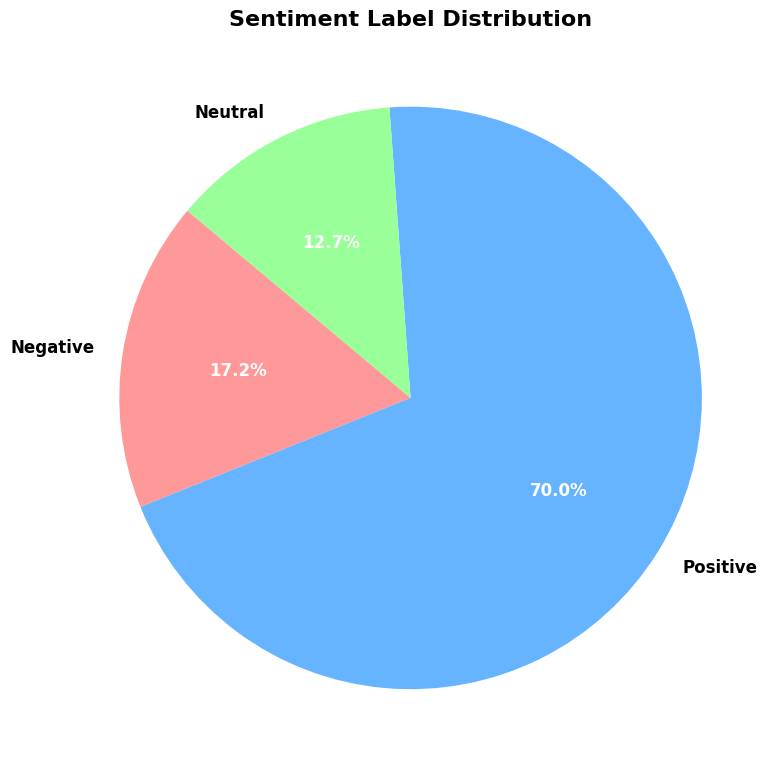

In [37]:
# Define readable labels
label_names = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}

# Get value counts
label_counts = df_all['label'].value_counts().sort_index()
labels = [label_names.get(i, i) for i in label_counts.index]
sizes = label_counts.values

# Define custom colors (optional)
colors = ['#ff9999', '#66b3ff', '#99ff99']  # Negative, Positive, Neutral

# Plot pie chart
plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12}
)

# Beautify
for text in texts:
    text.set_fontweight('bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.title('Sentiment Label Distribution', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Now that we have all duplicates removed and done a sanity check
- we can see that there is an overwhelming amount of positive reviews in our dataset.
- meaning our model might tend to overfit to the positive class because it's seen far more often.
- and that our model might struggle to learn neutral and negative patterns well


### We may proceed with tokenization and padding now

In [38]:
# Tokenize based only on training data to prevent info leakage
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_orig)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_orig)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
maxlen = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

# Parameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

# Initial Model Building

In [39]:
# Build the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),  
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes
])

# Compile
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

# Train the model and capture history
history = model.fit(
    X_train_pad,
    np.array(y_train_orig),
    epochs=15,
    batch_size=64,
    validation_split=0.1
)

Epoch 1/15
10/10 [==============================] - 20s 333ms/step - loss: 0.9978 - accuracy: 0.6596 - val_loss: 0.8466 - val_accuracy: 0.6957
Epoch 2/15
10/10 [==============================] - 1s 66ms/step - loss: 0.8453 - accuracy: 0.7099 - val_loss: 0.8270 - val_accuracy: 0.6957
Epoch 3/15
10/10 [==============================] - 0s 48ms/step - loss: 0.8126 - accuracy: 0.7099 - val_loss: 0.8198 - val_accuracy: 0.6957
Epoch 4/15
10/10 [==============================] - 0s 40ms/step - loss: 0.7732 - accuracy: 0.7099 - val_loss: 0.7880 - val_accuracy: 0.6957
Epoch 5/15
10/10 [==============================] - 0s 40ms/step - loss: 0.7442 - accuracy: 0.7099 - val_loss: 0.7210 - val_accuracy: 0.6957
Epoch 6/15
10/10 [==============================] - 0s 48ms/step - loss: 0.6567 - accuracy: 0.7099 - val_loss: 0.6144 - val_accuracy: 0.6957
Epoch 7/15
10/10 [==============================] - 0s 45ms/step - loss: 0.5493 - accuracy: 0.7358 - val_loss: 0.5024 - val_accuracy: 0.7536
Epoch 8/15


10/10 [==============================] - 0s 41ms/step


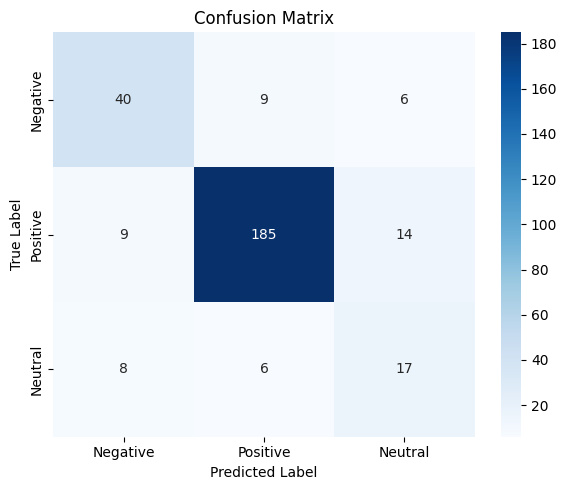

Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.73      0.71        55
    Positive       0.93      0.89      0.91       208
     Neutral       0.46      0.55      0.50        31

    accuracy                           0.82       294
   macro avg       0.70      0.72      0.71       294
weighted avg       0.83      0.82      0.83       294



In [76]:
# Predict class probabilities
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Negative', 'Positive', 'Neutral']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

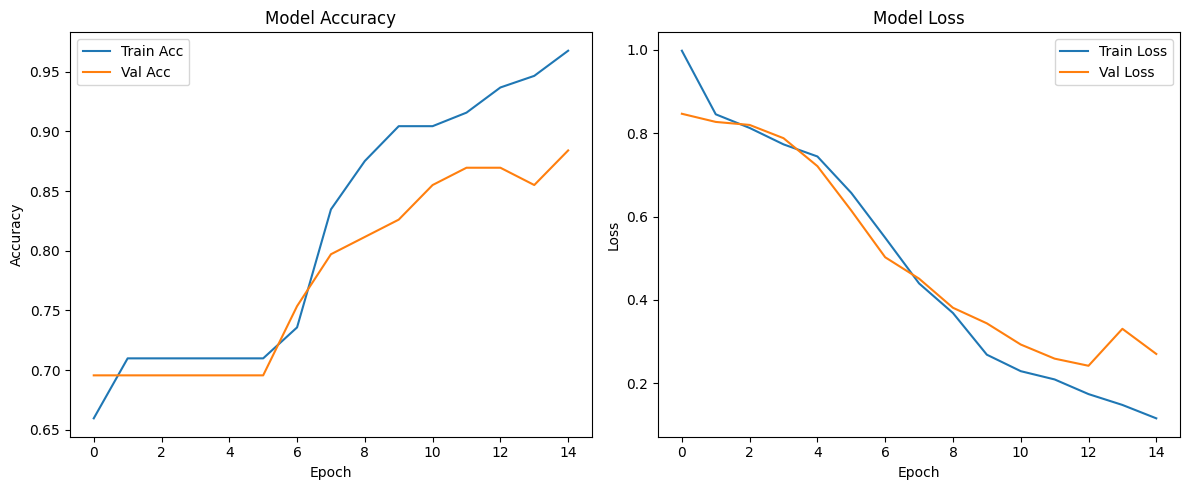

In [41]:
# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Observations after initial model build
- what we see upon seeing the confusion matrix:
  - Positive class is doing extremely well (recall = 0.89).
  - Neutral class is underperforming badly (recall = 0.73).
  - Negative is decent, but could use minor tuning.

# Hyperparameter tuning
- **what can we do to improve our hyperparams tuning?**
  - Adding class weights to penalize majority class

In [64]:
# Make sure labels are integers
y_train_int = np.array(y_train_orig).astype(int)

# Class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights = dict(enumerate(class_weights))


In [75]:
# Define search ranges
embedding_dims = [64, 100, 128]
lstm_units_list = [64, 128]
dense_units_list = [32, 64]
dropout_rates = [0.3, 0.4]
learning_rates = [1e-3, 5e-4, 1e-4]

# Number of random trials
n_trials = 50

# Storage
results = []
best_macro_recall = 0
best_model = None
best_history = None
best_trial_info = None

# Random search loop
for i in range(n_trials):
    print(f"\nTrial {i + 1} of {n_trials}")

    # Randomly sample hyperparameters
    emb_dim = random.choice(embedding_dims)
    lstm_units = random.choice(lstm_units_list)
    dense_units = random.choice(dense_units_list)
    dropout_rate = random.choice(dropout_rates)
    lr = random.choice(learning_rates)

    # Build model
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=maxlen),
        Bidirectional(LSTM(lstm_units, return_sequences=False)),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    # Train
    history = model.fit(
        X_train_pad, y_train_int,
        validation_split=0.1,
        epochs=30,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop],
        verbose=0
    )

    # Evaluate on validation
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]

    # Predict on test set
    y_pred = np.argmax(model.predict(X_test_pad), axis=1)
    report = classification_report(y_test, y_pred, output_dict=True)
    macro_recall = report['macro avg']['recall']

    # Log results
    results.append({
        'embedding_dim': emb_dim,
        'lstm_units': lstm_units,
        'dense_units': dense_units,
        'dropout': dropout_rate,
        'lr': lr,
        'val_accuracy': val_acc,
        'val_loss': val_loss,
        'macro_recall': macro_recall
    })

    # Save best model
    if macro_recall > best_macro_recall:
        best_macro_recall = macro_recall
        best_model = model
        best_history = history
        best_trial_info = {
            'embedding_dim': emb_dim,
            'lstm_units': lstm_units,
            'dense_units': dense_units,
            'dropout': dropout_rate,
            'lr': lr
        }

# Show top results
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='macro_recall', ascending=False)
print("\nTop Configurations by Macro Recall:")
print(df_results.head(5))



Trial 1 of 50
10/10 [==============================] - 2s 41ms/step

Trial 2 of 50


C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 2s 50ms/step

Trial 3 of 50
10/10 [==============================] - 2s 42ms/step

Trial 4 of 50
10/10 [==============================] - 2s 50ms/step

Trial 5 of 50
10/10 [==============================] - 2s 40ms/step

Trial 6 of 50
10/10 [==============================] - 2s 41ms/step

Trial 7 of 50
10/10 [==============================] - 2s 40ms/step

Trial 8 of 50


C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 2s 43ms/step

Trial 9 of 50
10/10 [==============================] - 2s 32ms/step

Trial 10 of 50
10/10 [==============================] - 2s 43ms/step

Trial 11 of 50
10/10 [==============================] - 2s 46ms/step

Trial 12 of 50
10/10 [==============================] - 2s 41ms/step

Trial 13 of 50
10/10 [==============================] - 2s 34ms/step

Trial 14 of 50
10/10 [==============================] - 2s 44ms/step

Trial 15 of 50


C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 2s 40ms/step

Trial 16 of 50
10/10 [==============================] - 2s 44ms/step

Trial 17 of 50
10/10 [==============================] - 2s 39ms/step

Trial 18 of 50
10/10 [==============================] - 3s 46ms/step

Trial 19 of 50
10/10 [==============================] - 2s 42ms/step

Trial 20 of 50


C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 2s 32ms/step

Trial 21 of 50
10/10 [==============================] - 2s 37ms/step


C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Trial 22 of 50
10/10 [==============================] - 2s 42ms/step

Trial 23 of 50


C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 2s 41ms/step

Trial 24 of 50
10/10 [==============================] - 2s 32ms/step

Trial 25 of 50
10/10 [==============================] - 2s 33ms/step


C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Trial 26 of 50
10/10 [==============================] - 4s 44ms/step

Trial 27 of 50
10/10 [==============================] - 2s 33ms/step

Trial 28 of 50
10/10 [==============================] - 2s 40ms/step

Trial 29 of 50
10/10 [==============================] - 2s 47ms/step

Trial 30 of 50
10/10 [==============================] - 2s 53ms/step

Trial 31 of 50
10/10 [==============================] - 3s 41ms/step

Trial 32 of 50


C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 2s 46ms/step

Trial 33 of 50
10/10 [==============================] - 2s 46ms/step

Trial 34 of 50


C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 2s 43ms/step

Trial 35 of 50


C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 2s 42ms/step

Trial 36 of 50


C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 2s 41ms/step

Trial 37 of 50
10/10 [==============================] - 2s 41ms/step

Trial 38 of 50


C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 2s 40ms/step

Trial 39 of 50
10/10 [==============================] - 2s 41ms/step

Trial 40 of 50
10/10 [==============================] - 2s 44ms/step

Trial 41 of 50
10/10 [==============================] - 2s 34ms/step

Trial 42 of 50


C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 2s 35ms/step

Trial 43 of 50
10/10 [==============================] - 2s 47ms/step

Trial 44 of 50
10/10 [==============================] - 2s 40ms/step

Trial 45 of 50
10/10 [==============================] - 2s 39ms/step

Trial 46 of 50


C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavier Lee\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 3s 42ms/step

Trial 47 of 50
10/10 [==============================] - 4s 47ms/step

Trial 48 of 50
10/10 [==============================] - 2s 49ms/step

Trial 49 of 50
10/10 [==============================] - 3s 47ms/step

Trial 50 of 50
10/10 [==============================] - 2s 42ms/step

Top Configurations by Macro Recall:
    embedding_dim  lstm_units  dense_units  dropout      lr  val_accuracy  \
14            100         128           32      0.4  0.0010      0.913043   
17            128          64           32      0.4  0.0010      0.913043   
38            100         128           32      0.3  0.0005      0.913043   
23            128          64           64      0.3  0.0005      0.942029   
5              64          64           32      0.3  0.0010      0.898551   

    val_loss  macro_recall  
14  0.248537      0.761962  
17  0.265550      0.757741  
38  0.235731      0.755902  
23  0.262657      0.744130  
5   0.362807      0.7

10/10 [==============================] - 0s 33ms/step


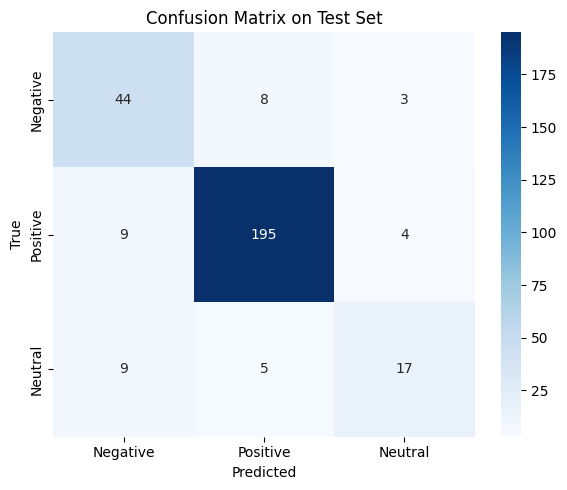

Best Hyperparameters: {'embedding_dim': 100, 'lstm_units': 128, 'dense_units': 32, 'dropout': 0.4, 'lr': 0.001}
Classification Report:
              precision    recall  f1-score   support

    Negative       0.71      0.80      0.75        55
    Positive       0.94      0.94      0.94       208
     Neutral       0.71      0.55      0.62        31

    accuracy                           0.87       294
   macro avg       0.79      0.76      0.77       294
weighted avg       0.87      0.87      0.87       294



In [77]:
# Evaluate final performance on test set
y_pred = np.argmax(best_model.predict(X_test_pad), axis=1)
cm = confusion_matrix(y_test, y_pred)
labels = ['Negative', 'Positive', 'Neutral']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.show()

# Print report
print("Best Hyperparameters:", best_trial_info)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

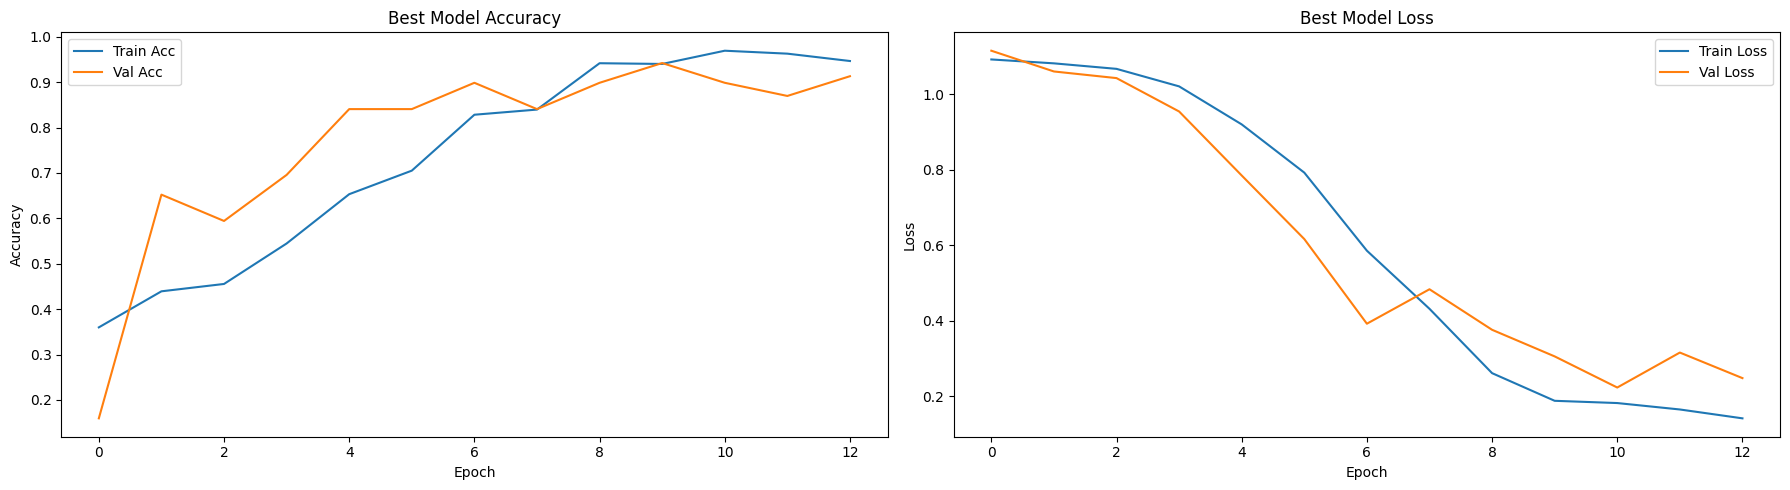

In [78]:
# Plot training history of best model
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'], label='Train Acc')
plt.plot(best_history.history['val_accuracy'], label='Val Acc')
plt.title('Best Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Val Loss')
plt.title('Best Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Observations after hypertuning:
Our model has significantly improved in robustness, class balance, and generalization compared to the base model.

Positive class remains dominant and highly predictable.

Neutral class recall improved (from 0.31 → 0.55), indicating better detection of subtle sentiment.

Negative class has also improved recall (0.68 → 0.80), meaning fewer false negatives.

In [79]:
# Save best model weights
best_model.save("best_sentiment_model_weights.h5")

print("Best model weights saved to 'best_sentiment_model_weights.h5'")

Best model weights saved to 'best_sentiment_model_weights.h5
